# Data Exploration and Pre-Processing

## 1 Investigation

In [81]:
import os
import nibabel as nib
import gzip
from PIL import Image

# get notebook path
path = os.path.abspath('')
path = path.split('/')
path = '/'.join(path[:-1])
print(path)

def read_image(file_path):
    nii_img = nib.load(file_path)
    image_data = nii_img.get_fdata()
    header = nii_img.header
    return image_data, header

In [82]:
image_data, _ = read_image(os.path.join(path, 'data_dev/train/images/RibFrac421-image.nii.gz'))
label_data, header = read_image(os.path.join(path, 'data_dev/train/labels/RibFrac421-label.nii.gz'))

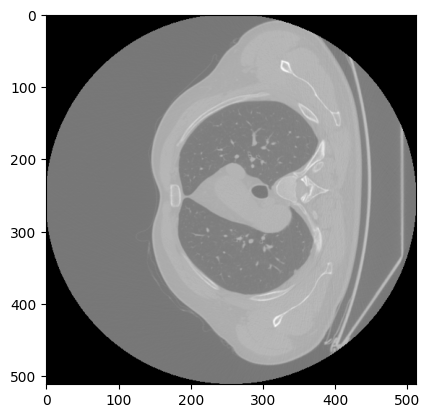

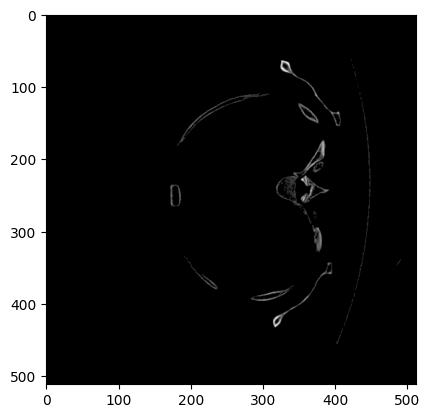

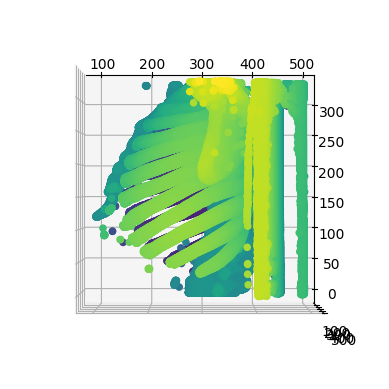

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# plot the image
plt.imshow(image_data[:,:,240], cmap='gray')
plt.show()

def imagerelu(x):
    return np.where(np.asarray(x) > 200, x, 0)

# plot transformed image
image_data_transformed = imagerelu(image_data)

plt.imshow(image_data_transformed[:,:,240], cmap='gray')
plt.show()

#plot 3D sideview. Might take a bit of time.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = image_data_transformed.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)
ax.view_init(90,-90)
plt.show()


In [4]:
print(label_data.shape)
print(header)

(512, 512, 325)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 325   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.878906 0.878906 1.25     0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 203.6
qoffset_y       : 225.0
qoffset_z 

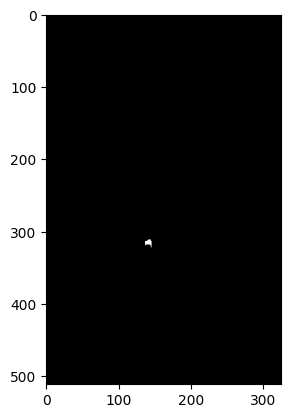

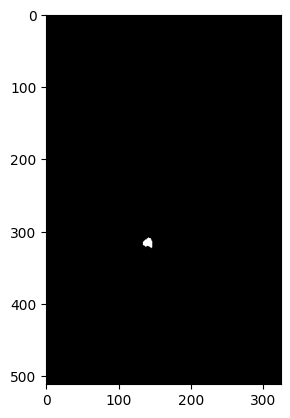

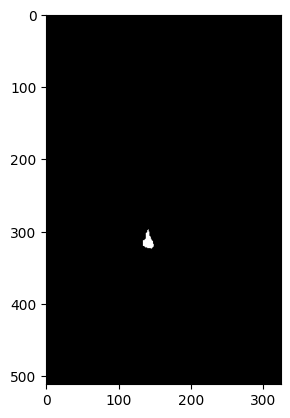

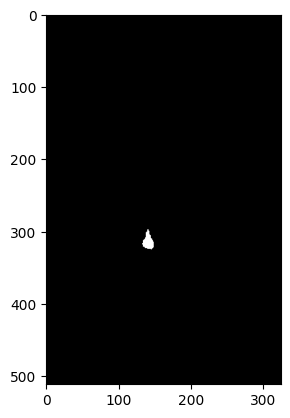

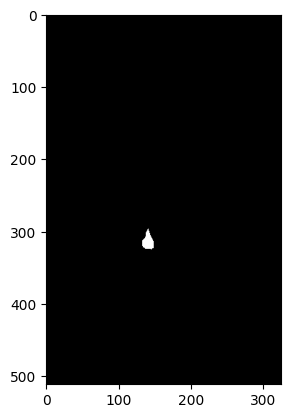

In [5]:
# plot the slices with annotation
count = 0
for slice in label_data:
    if slice.sum() > 0:
        plt.imshow(slice, cmap="gray")
        plt.show()
        count += 1
        if count == 5:
            break

## 2 Pre-Processing

### Making them all the same shape

I do not hink this is a good approach because it adds latency to the data loading.
We should rather downsample the 3rd dimension.
Maybe after downsampling apply this function.

In [ ]:
import numpy as np
from tqdm import tqdm as tqmd

override = False
mode = 'val' # 'train', 'val', 'test'

# find image with the most slices in 3rd dimension
max_slices = 0
print("finding largest file...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
    if image_data.shape[2] > max_slices:
        max_slices = image_data.shape[2]
        max_slices_file = file
print("largest file, size:", max_slices_file, max_slices)

# make a new folder to store the preprocessed data
if not os.path.exists(os.path.join(path, 'data/preprocessed')):
    os.makedirs(os.path.join(path, 'data/preprocessed'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels'))

# pad all images to the same size
print("pre-processing images...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    # check if file has been processed
    if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)):
        image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
        label_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-labels', file.replace('image', 'label')))
        if image_data.shape[2] < max_slices:
            image_data = np.pad(image_data, ((0, 0), (0, 0), (0, max_slices - image_data.shape[2])), 'constant')
            label_data = np.pad(label_data, ((0, 0), (0, 0), (0, max_slices - label_data.shape[2])), 'constant')
            nib.save(
                nib.Nifti1Image(image_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)
                )
            nib.save(
                nib.Nifti1Image(label_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels', file.replace('image', 'label'))
                )

### Make labels all 1 instead of 1, 2, 3, 4, -1 WIP

In [80]:
print(label_data)

def labelchange(x):
    return np.where(np.asarray(x) > 0 , x, 0)

print(labelchange(label_data))

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0